# Imputing LotFrontage NaN values through Linear Regression

Intuitively, LotFrontage plays a significant influence while determining Market Value of a Real Property. It is the length of the exposure street the front of a property has. In the Ames House Price dataset, LotFrontage has significant no. of NaN values; ~250. We suspect these are not missing at random. So, we'll try to impute the values with the help of other variables.

Based on our prior understanding (and common sense):
* LotArea should be correlated with LotFrontage, if not linear.
* LotConfig of Corner plots and CulDSac plots with have greater LotFrontage than Inside lots.
* Regular shaped and Irregular shaped lots are likely to have different relationship with LotFrontage
* Ally, among other variables, may indicate geometry of the lot.
* Different MSZoning classes may have different average LotFront.
* BldgType also affect LotFrontage; for e.g., Townhouse has much more narrow footprint than a detached house.
* Different Neighboorhood classes are likely to have different mean LotFrontage.
* Condition1 and Condition2 can serve as markers for lot location withing the neighborhood
* Unless the garage faces the Alley, GarageType is also likely to influence the LotFrontage
* No. of GarageCars will also affect LotFrontage.

Therefore we will try to impute LotFrontage values with the help of the above state variables.

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', 100)

In [3]:
dataset = pd.read_csv('house_prices_advanced_regression_techniques/train.csv', usecols=['LotArea', 'LotConfig', 'LotShape', 'Alley', 'MSZoning', 'BldgType', 'Neighborhood', 'Condition1', 'Condition2', 'GarageCars', 'LotFrontage'])
data = dataset.copy(deep=True)

train = data[~data['LotFrontage'].isnull()]
test = data[data['LotFrontage'].isnull()]

X_train, y_train = train.drop(labels=['LotFrontage'], axis=1), train['LotFrontage']
X_test, y_test = test.drop(labels=['LotFrontage'], axis=1), test['LotFrontage']

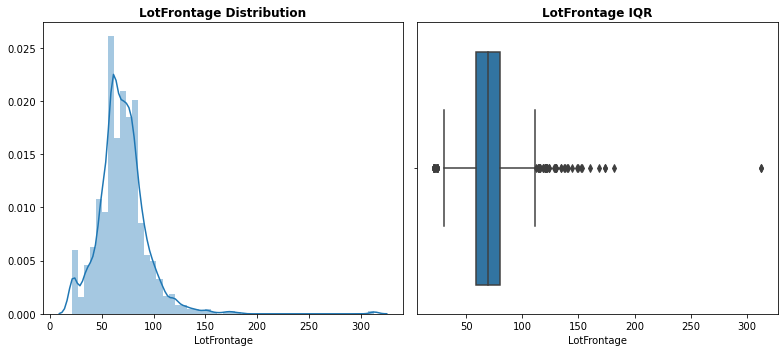

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
sns.distplot(y_train, ax=axs[0]);
axs[0].set_xlabel('LotFrontage')
axs[0].set_title('LotFrontage Distribution', fontweight='semibold')
sns.boxplot(y_train, ax=axs[1]);
axs[1].set_xlabel('LotFrontage')
axs[1].set_title('LotFrontage IQR', fontweight='semibold')
plt.tight_layout()
plt.show()

A function to detect outlier

In [5]:
def idOutliers(data):
    q25 = data.describe()[4]
    q75 = data.describe()[6]
    iqr = q75 - q25
    out = (data > q75+1.5 * iqr) | (data < q25 - 1.5 * iqr)
    return out

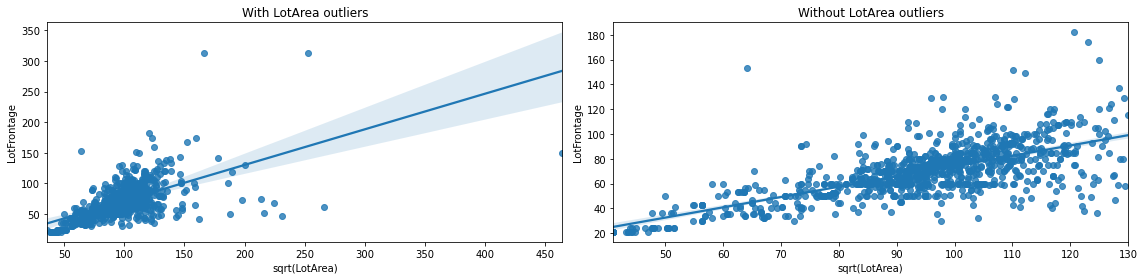

In [6]:
# Exploring relationship between LotArea and LotFrontage
fig, ax =plt.subplots(1,2, figsize=(16,4))
ax[0].set_title('With LotArea outliers')
ax[1].set_title('Without LotArea outliers')
sns.regplot(X_train.LotArea.apply(np.sqrt), y_train, ax=ax[0])
ax[0].set(xlabel='sqrt(LotArea)')
sns.regplot(X_train.LotArea[~idOutliers(X_train.LotArea)].apply(np.sqrt), y_train[~idOutliers(X_train.LotArea)], ax=ax[1])
ax[1].set(xlabel='sqrt(LotArea)');
plt.tight_layout()
plt.show()

The above plot indicates, a positive relationship and presence of heteroscedacity between LotArea and LotFrontage. Variance in LotFrontage is not uniform across the range of LotArea.

Let's explore whether other variables can explain this variance.

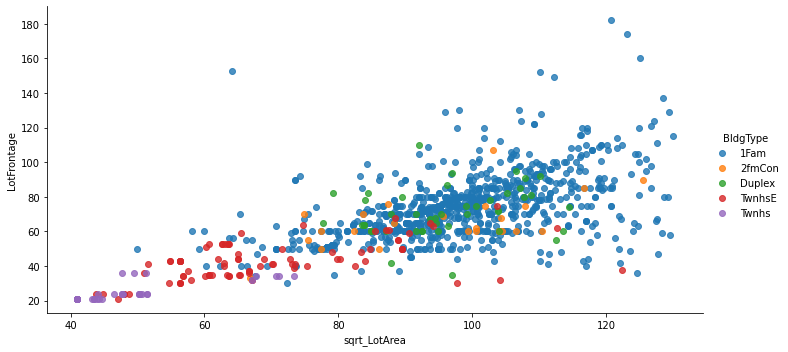

In [7]:
train_plot = train[~idOutliers(X_train.LotArea)].copy()
train_plot['sqrt_LotArea'] = train_plot['LotArea'].apply(np.sqrt)
sns.lmplot(x='sqrt_LotArea', y='LotFrontage', hue='BldgType', aspect=2, fit_reg=False, data=train_plot);
plt.show()

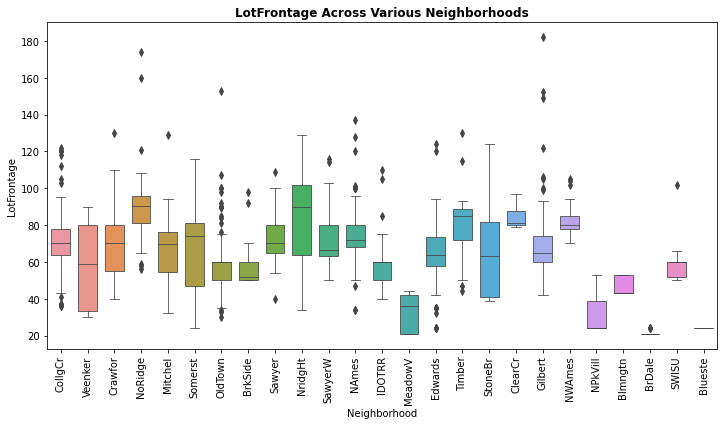

In [8]:
# LotFrontage across various Neighborhood labels
plt.figure(figsize=(12,6))
sns.boxplot(x=train_plot['Neighborhood'], y=train_plot['LotFrontage'], width=0.7, linewidth=0.8)
plt.xticks(rotation=90)
plt.title('LotFrontage Across Various Neighborhoods', fontweight='semibold')
plt.show()

Further, we suspect houses with no Alley access are likely to have higher median LotFrontage. Gravel Alley access seems to be tightly bound, except to outliers, to a short range of LotFrontage.

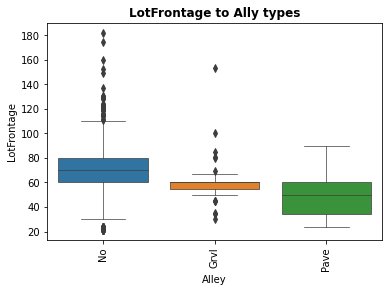

In [9]:
train_plot['Alley'] = train_plot['Alley'].fillna('No')
sns.boxplot(x=train_plot['Alley'], y=train_plot['LotFrontage'], linewidth=0.7);
plt.xticks(rotation=90)
plt.title('LotFrontage to Ally types', fontweight='semibold')
plt.show()

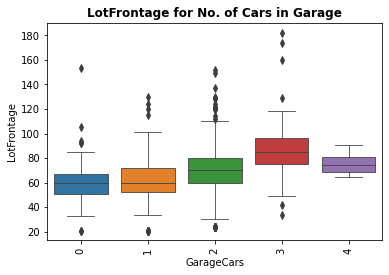

In [10]:
# GarageCars vs. LotFrontage
sns.boxplot(x=train_plot['GarageCars'], y=train_plot['LotFrontage'], linewidth=0.8);
plt.xticks(rotation=90)
plt.title('LotFrontage for No. of Cars in Garage',fontweight='semibold')
plt.show()

With the intuition we have developed, let's now build a model that captures above relationships.

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder

In [12]:
categorical = [i for i in data.columns.tolist() if data[i].dtype=='O']
categorical

['MSZoning',
 'Alley',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType']

In [13]:
for i in categorical:
    print(i)
    if X_train[i].isnull().any():
        X_train[i].fillna('No', inplace=True)
    if X_test[i].isnull().any():
        X_test[i].fillna('No', inplace=True)
#     print(X_train[i].value_counts(dropna=False))
#     print('='*10)

pd.concat([X_train.isnull().sum(), X_test.isnull().sum()], axis=1)

MSZoning
Alley
LotShape
LotConfig
Neighborhood
Condition1
Condition2
BldgType


,0,1
MSZoning,0,0
LotArea,0,0
Alley,0,0
LotShape,0,0
LotConfig,0,0
Neighborhood,0,0
Condition1,0,0
Condition2,0,0
BldgType,0,0
GarageCars,0,0


In [15]:
pipe = Pipeline([('rare_label_encode',RareLabelCategoricalEncoder(n_categories=5, variables=categorical, replace_with='other')), 
                 ('ohc_encode', OneHotCategoricalEncoder(top_categories=3, variables=categorical, drop_last=True)), 
                 ('scaler', StandardScaler()), 
                 ('model', SVR(kernel='rbf', C=100, gamma=0.001))])

# col_list = ['LotArea','GarageCars','MSZoning_RL','MSZoning_RM','MSZoning_FV','Alley_No','Alley_Grvl','Alley_Pave',
#             'LotShape_Reg','LotShape_IR1','LotShape_IR2','LotConfig_Inside','LotConfig_Corner','LotConfig_CulDSac',
#             'Neighborhood_other','Neighborhood_NAmes','Neighborhood_CollgCr','Condition1_Norm','Condition1_other',
#             'Condition1_Feedr','Condition2_Norm','Condition2_other','BldgType_1Fam','BldgType_TwnhsE',
#             'BldgType_Duplex']

# X_train = pd.DataFrame(pipe.fit_transform(X_train), columns=col_list)



# initial scores
accuracy = 0

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
for trn, tst in k_fold.split(train):
    pipe.fit(X_train.iloc[trn,:], y_train.iloc[trn])
    y_pred = pipe.predict(X_train.iloc[tst,:])
    accuracy += mean_absolute_error(y_train.iloc[tst], y_pred)

/home/nm/miniconda3/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable LotShape is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/hom

In [16]:
print('Root Mean Absolute Error: %.4f' % (accuracy/5))

Root Mean Absolute Error: 10.6527


In [18]:
y_pred_test = pipe.predict(X_test)

In [19]:
joblib.dump(value=y_pred_test, filename='imputed_values.pkl')

['imputed_values.pkl']